# TO DO

- question 1: you have checked the top sports, check the least popular sports too. 

# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [4]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


# DEFINITION OF INDEX

from here https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/2033.0.55.001~2016~Main%20Features~IRSAD~20

4 major indexes for every LGA. 

**IRSAD: index of relative socio economic advantage and disadvantage.**
- summarises information about the economic and social conditions of people and households within an area. Includes both relative advantage and disadvantage. 
- low score = greater disadvatange, lack of advantage in general. 
- low scores = many households with low incomes, many people in unskilled occupations. OR few households with high incomes. Few people in skilled occupations. 

**IEO: Index of education and occupation.**
- reflects the educational and occupational level of communities. 
- Education variables in this index show either the level of qualification achieved or wheteher further education is being undertaken. 
- Low score = relatively lower education and occupation status. 
- low score = many people without qualifications or many people in low skilled occuaptions or unemployed. AND few people with high level of qualification or highly skilled occupation. 

**IER: Index of economic resources.**
- focus' on the financial aspects of relative socio-economic advantage and disadvantage. Summarises variables related to income and wealth. 
- low score = relative lack to economic resources in general. 
- low score = many households with low income, or many paying low rent. AND few households with high income, or few owned homes. 

**IRSD: The index of relative socio economic disadvantage.**
- range of information about the economic and social conditions of people and households. 
- low score = relatively greater disadvantage in general. 
- low sore= many households with low income, people with no qualification OR many people in low skill occupations. 

### Voucher dataset
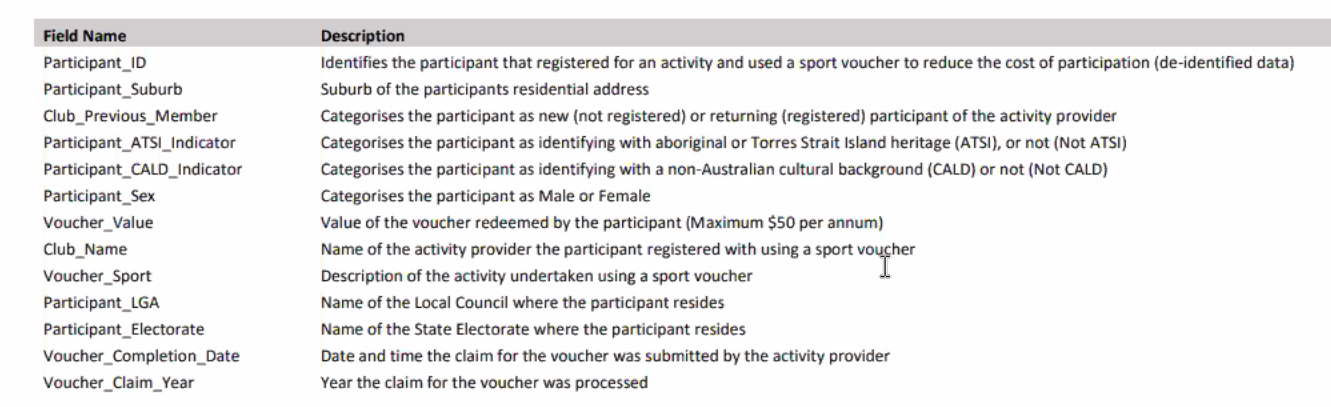

# Q1 Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?

We can assume each row means a voucher has been claimed. 

Start off by checking how many unique LGAs there are. Then we can count how many times the LGA occurs. 

In [6]:
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [7]:
len(set(sa_vouchers_scores['Participant_LGA']))

69

In [8]:
lgaSportGrouped = (sa_vouchers_scores.groupby(['Participant_LGA','Voucher_Sport']).count()).copy(deep=True)

In [9]:
lgaSportGrouped

Participant_ID  Participant_Suburb  \
Participant_LGA Voucher_Sport                                          
ADELAIDE        Athletics                     16                  16   
                Australian Rules             130                 130   
                Baseball                       1                   1   
                Basketball                     4                   4   
                Calisthenics                   1                   1   
...                                          ...                 ...   
YORKE PENINSULA Motorcycling                   2                   2   
                Netball                      313                 313   
                Surf Lifesaving                4                   4   
                Taekwondo                     87                  87   
                Tennis                         9                   9   

                                  Club_Previous_Member  \
Participant_LGA Voucher_Sport                            
ADELAIDE        Athletics                           16   
                Australian Rules                   130   
                Baseball                             1   
                Basketball                           4   
                Calisthenics                         1   
...                                                ...   
YORKE PENINSULA Motorcycling                         2   
                Netball                            313   
                Surf Lifesaving                      4   
                Taekwondo                           87   
                Tennis                               9   

                                  Participant_ATSI_Indicator  \
Participant_LGA Voucher_Sport                                  
ADELAIDE        Athletics                                 16   
                Australian Rules                         130   
                Baseball                                   1   
                Basketball                                 4   
                Calisthenics                               1   
...                                                      ...   
YORKE PENINSULA Motorcycling                               2   
                Netball                                  313   
                Surf Lifesaving                            4   
                Taekwondo                                 87   
                Tennis                                     9   

                                  Participant_CALD_Indicator  Participant_Sex  \
Participant_LGA Voucher_Sport                                                   
ADELAIDE        Athletics                                 16               16   
                Australian Rules                         130              130   
                Baseball                                   1                1   
                Basketball                                 4                4   
                Calisthenics                               1                1   
...                                                      ...              ...   
YORKE PENINSULA Motorcycling                               2                2   
                Netball                                  313              313   
                Surf Lifesaving                            4                4   
                Taekwondo                                 87               87   
                Tennis                                     9                9   

                                  Voucher_Value  Club_Name  \
Participant_LGA Voucher_Sport                                
ADELAIDE        Athletics                    16         16   
                Australian Rules            130        130   
                Baseball                      1          1   
                Basketball                    4          4   
                Calisthenics                  1          1   
...                  

In [10]:
adelaide = lgaSportGrouped[lgaSportGrouped.index.get_level_values('Participant_LGA') == 'ADELAIDE']

C:\Users\Rudol\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


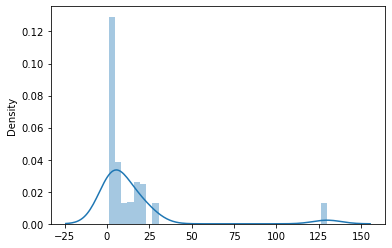

In [11]:
sns.distplot(lgaSportGrouped[lgaSportGrouped.index.get_level_values('Participant_LGA') == 'ADELAIDE'])

In [12]:
adelaide['Participant_ID']

Participant_LGA  Voucher_Sport    
ADELAIDE         Athletics             16
                 Australian Rules     130
                 Baseball               1
                 Basketball             4
                 Calisthenics           1
                 Cricket                2
                 Diving                 5
                 Fencing                3
                 Football (Soccer)     27
                 Golf                   1
                 Gymnastics            20
                 Hockey                17
                 Judo                   4
                 Lacrosse               8
                 Netball               23
                 Orienteering           6
                 Rugby Union            3
                 Softball               2
                 Surf Lifesaving       14
                 Taekwondo             11
                 Tennis                 4
Name: Participant_ID, dtype: int64

# check groupby and pivot table to do this better. 

In [13]:
sportNames = adelaide.index.get_level_values('Voucher_Sport').values

In [14]:
test = pd.DataFrame({'sport':sportNames, 'count': adelaide['Participant_ID'].values})

In [15]:
test['sport'].iloc[0]

'Athletics'

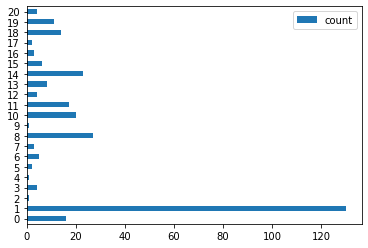

In [16]:
test.plot.barh()

Checking the top ten sports

https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.nlargest.html

### let's try the above but with a pivot table instead 

used help from the textbook for this part. Page 24, section 2.6.8



In [17]:
group = (sa_vouchers_scores.groupby(['Participant_LGA','Voucher_Sport']).count()).copy(deep=True)

In [18]:
group.columns

Index(['Participant_ID', 'Participant_Suburb', 'Club_Previous_Member',
       'Participant_ATSI_Indicator', 'Participant_CALD_Indicator',
       'Participant_Sex', 'Voucher_Value', 'Club_Name',
       'Participant_Electorate', 'Voucher_Completion_Date',
       'Voucher_Claim_Year', 'IEO', 'IER', 'IRSAD', 'IRSD', 'Population'],
      dtype='object')

keeping all rows and only keeping one column. All the columns represent the same number of counts, so we only need to keep one. 

In [19]:
group

Participant_ID  Participant_Suburb  \
Participant_LGA Voucher_Sport                                          
ADELAIDE        Athletics                     16                  16   
                Australian Rules             130                 130   
                Baseball                       1                   1   
                Basketball                     4                   4   
                Calisthenics                   1                   1   
...                                          ...                 ...   
YORKE PENINSULA Motorcycling                   2                   2   
                Netball                      313                 313   
                Surf Lifesaving                4                   4   
                Taekwondo                     87                  87   
                Tennis                         9                   9   

                                  Club_Previous_Member  \
Participant_LGA Voucher_Sport                            
ADELAIDE        Athletics                           16   
                Australian Rules                   130   
                Baseball                             1   
                Basketball                           4   
                Calisthenics                         1   
...                                                ...   
YORKE PENINSULA Motorcycling                         2   
                Netball                            313   
                Surf Lifesaving                      4   
                Taekwondo                           87   
                Tennis                               9   

                                  Participant_ATSI_Indicator  \
Participant_LGA Voucher_Sport                                  
ADELAIDE        Athletics                                 16   
                Australian Rules                         130   
                Baseball                                   1   
                Basketball                                 4   
                Calisthenics                               1   
...                                                      ...   
YORKE PENINSULA Motorcycling                               2   
                Netball                                  313   
                Surf Lifesaving                            4   
                Taekwondo                                 87   
                Tennis                                     9   

                                  Participant_CALD_Indicator  Participant_Sex  \
Participant_LGA Voucher_Sport                                                   
ADELAIDE        Athletics                                 16               16   
                Australian Rules                         130              130   
                Baseball                                   1                1   
                Basketball                                 4                4   
                Calisthenics                               1                1   
...                                                      ...              ...   
YORKE PENINSULA Motorcycling                               2                2   
                Netball                                  313              313   
                Surf Lifesaving                            4                4   
                Taekwondo                                 87               87   
                Tennis                                     9                9   

                                  Voucher_Value  Club_Name  \
Participant_LGA Voucher_Sport                                
ADELAIDE        Athletics                    16         16   
                Australian Rules            130        130   
                Baseball                      1          1   
                Basketball                    4          4   
                Calisthenics                  1          1   
...                  

In [20]:
group.loc[:, 'Participant_ID' ]

Participant_LGA  Voucher_Sport   
ADELAIDE         Athletics            16
                 Australian Rules    130
                 Baseball              1
                 Basketball            4
                 Calisthenics          1
                                    ... 
YORKE PENINSULA  Motorcycling          2
                 Netball             313
                 Surf Lifesaving       4
                 Taekwondo            87
                 Tennis                9
Name: Participant_ID, Length: 1157, dtype: int64

we would use the below format to index into the series. Useful for filtering out the top ten sports, for example. We just specify which LGA we're interested in we will have the cocunts for eacch sport. 

perhaps this can be changed to have each column as a sport, each row as an LGA. I think this is where pivot table comes in handy. 

In [21]:
pivot = pd.pivot_table(group, values = 'Participant_ID', index = 'Participant_LGA', columns = 'Voucher_Sport')

In [22]:
pivot

Voucher_Sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,NaN,16.0,130.0,NaN,NaN,1.0,4.0,NaN,1.0,2.0,...,NaN,NaN,NaN,11.0,4.0,NaN,NaN,NaN,NaN,NaN
ADELAIDE HILLS,3.0,204.0,1412.0,2.0,NaN,11.0,48.0,NaN,62.0,128.0,...,NaN,18.0,3.0,44.0,257.0,2.0,1.0,1.0,NaN,NaN
ADELAIDE PLAINS,NaN,3.0,485.0,NaN,NaN,3.0,15.0,NaN,23.0,3.0,...,NaN,3.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN
ALEXANDRINA,9.0,62.0,980.0,4.0,3.0,NaN,204.0,NaN,5.0,8.0,...,2.0,11.0,NaN,NaN,109.0,NaN,NaN,NaN,NaN,NaN
BAROSSA,NaN,158.0,1196.0,3.0,NaN,6.0,341.0,NaN,9.0,56.0,...,NaN,12.0,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,1.0,114.0,907.0,2.0,NaN,12.0,70.0,NaN,45.0,85.0,...,NaN,80.0,4.0,27.0,158.0,1.0,4.0,2.0,NaN,NaN
WHYALLA,NaN,15.0,569.0,NaN,NaN,NaN,605.0,NaN,15.0,12.0,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WUDINNA,NaN,29.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
pivot = pivot.fillna(0)

before this step we had a series of 1100 odd rows. That in itself isn't too bad, but applying the pivot table has drastically aided in the dimensioniality of the DF,m making it easier to explore the D. I have also changed the NAN values to zero, making the assumption that the nan values represent no voucher redeemed. 

Let's try some plots with this new df now. 

from https://seaborn.pydata.org/examples/part_whole_bars.html

**Removing any uppercase words for ease of referencing the DF.**

help from https://www.codegrepper.com/code-examples/python/convert+columns+to+lowercase+pandas

In [24]:
pivot.index = pivot.index.str.lower()

In [25]:
pivot.columns = pivot.columns.str.lower()

In [26]:
pivot.loc[['adelaide','adelaide hills'], ['archery','athletics']]

Voucher_Sport,archery,athletics
Participant_LGA,,
adelaide,0.0,16.0
adelaide hills,3.0,204.0


In [27]:
pivot.head()

Voucher_Sport,archery,athletics,australian rules,bmx,badminton,baseball,basketball,bowls,calisthenics,cricket,...,surf riding,swimming,table tennis,taekwondo,tennis,touch,volleyball,water polo,weightlifting,wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
adelaide,0.0,16.0,130.0,0.0,0.0,1.0,4.0,0.0,1.0,2.0,...,0.0,0.0,0.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0
adelaide hills,3.0,204.0,1412.0,2.0,0.0,11.0,48.0,0.0,62.0,128.0,...,0.0,18.0,3.0,44.0,257.0,2.0,1.0,1.0,0.0,0.0
adelaide plains,0.0,3.0,485.0,0.0,0.0,3.0,15.0,0.0,23.0,3.0,...,0.0,3.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
alexandrina,9.0,62.0,980.0,4.0,3.0,0.0,204.0,0.0,5.0,8.0,...,2.0,11.0,0.0,0.0,109.0,0.0,0.0,0.0,0.0,0.0
barossa,0.0,158.0,1196.0,3.0,0.0,6.0,341.0,0.0,9.0,56.0,...,0.0,12.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,0.0


rank works such that each column has a new ranking. 1 being the highest rank (and so highest value in the original DF). 

In [28]:
rank = pivot.rank(ascending = False, method='first')

to check which lga has the most claimed vouchers. Onkaparinga being number one with most claimed vouchers.

In [29]:
totalClaimed = pivot.sum(axis=1)
totalClaimed.rank(ascending=False, method='dense').sort_values().head()

Participant_LGA
onkaparinga       1.0
salisbury         2.0
tea tree gully    3.0
playford          4.0
charles sturt     5.0
dtype: float64

In [30]:
pivot['athletics'].nlargest(10)

Participant_LGA
onkaparinga              541.0
charles sturt            447.0
port adelaide enfield    298.0
tea tree gully           280.0
marion                   238.0
salisbury                214.0
adelaide hills           204.0
burnside                 203.0
mitcham                  176.0
campbelltown             162.0
Name: athletics, dtype: float64

the `idxmax` function determines the most popular sports and we can easily display which sports are found via the `set` function 

In [31]:
set(pivot.idxmax(axis=1))

{'australian rules', 'basketball', 'football (soccer)', 'netball', 'swimming'}

In [32]:
topSports = list(set(pivot.idxmax(axis=1)))

So now we've found which sports stand out. These are the top 5 sports that are the most popular. 

Let's plot this to see how these top 5 sports vary in popularity among themselves. 

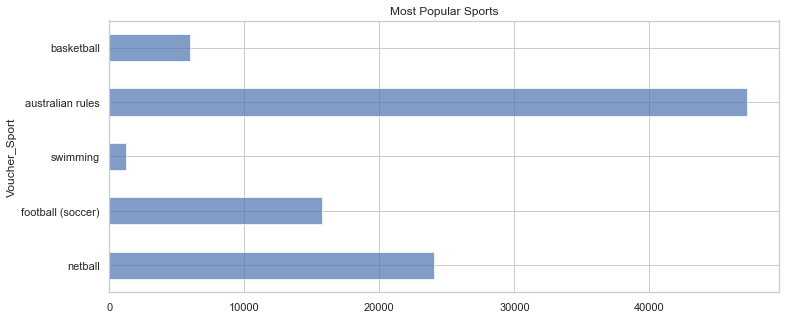

In [33]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))


pivot[topSports].sum().plot(kind='barh', style='b', alpha=0.7,
              title='Most Popular Sports')



order bar chart by the magnitude (there's a function for  it )

We can see Australian Rules and Netball are the most popular. We expect this as we know most Australians play these sports growing up. Other factors that can be included may be the regions in which these sports are played. Some LGAs may have a higher voucher claim rate than others. 

Similarly, let's now begin the process to check which are the top LGAs for claimed vouchers. 

In [34]:
topLGAs = list(set(pivot.idxmax(axis=0)))

The following will tell us the top sports for the specific LGA. 

In [35]:
pivot.loc[topLGAs[0]].sort_values().nlargest(5)

Voucher_Sport
australian rules     5258.0
netball              2242.0
gymnastics           1211.0
football (soccer)    1204.0
athletics             541.0
Name: onkaparinga, dtype: float64

In [36]:
totalClaimed_top5 = totalClaimed.sort_values(ascending=False).nlargest(5)

In [37]:
totalClaimed_top5

Participant_LGA
onkaparinga       12782.0
salisbury          8169.0
tea tree gully     7219.0
playford           6940.0
charles sturt      6897.0
dtype: float64

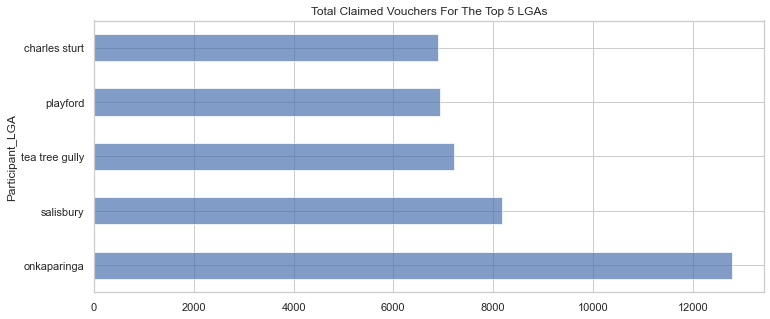

In [38]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))


totalClaimed_top5.plot(kind='barh', style='b', alpha=0.7,
              title='Total Claimed Vouchers For The Top 5 LGAs')

Onkaparinga stands out the most for total claimed vouchers within the LGA. Let's check what the most popular sports are in that LGA: 

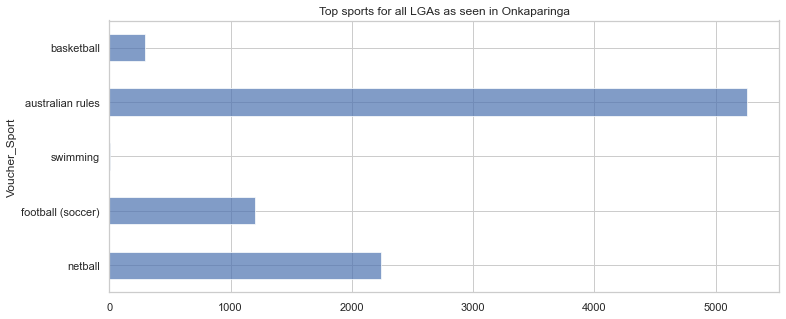

In [39]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))


pivot[topSports].loc['onkaparinga'].plot(kind='barh', style='b', alpha=0.7,
              title='Top sports for all LGAs as seen in Onkaparinga')

We can see Australian Rules dominates in this LGA compared to the other most popular sports. It could also be there are other sports in this LGA that are popular but did not make the cut in the `topSports` process. This may be due to the other popular sports within Onkaparinga may not be popular ni other LGAs. 

Comparing this plot to the plot for the most popular sports, we also notice Onkaparinga accounts for approximately 1/9$^{th}$ of the total claimed vouchers for Australian rules.

# Q2 Are some sports more popular in different parts of the state?

We have the ranking for each sport, so we can sort them to see which LGA is most popular. 

In [40]:
rank['archery'].sort_values().nsmallest(5)

Participant_LGA
alexandrina       1.0
victor harbor     2.0
adelaide hills    3.0
onkaparinga       4.0
yankalilla        5.0
Name: archery, dtype: float64

Perhaps we can use a for loop for plotting the popluarity of each sport. Do we want to plot all the sports or just the top ten sports? 

In [41]:
pivot.archery.sort_values().nlargest(5)

Participant_LGA
alexandrina       9.0
victor harbor     8.0
yankalilla        3.0
adelaide hills    3.0
onkaparinga       3.0
Name: archery, dtype: float64

In [42]:
for i in topSports: 
    print(rank[i].sort_values().nsmallest(5))
    print('')
    print(pivot[i].sort_values().nlargest(5))
    print('----------------------------------')



Participant_LGA
onkaparinga       1.0
adelaide hills    2.0
tea tree gully    3.0
playford          4.0
mount barker      5.0
Name: netball, dtype: float64

Participant_LGA
onkaparinga       2242.0
adelaide hills    1395.0
tea tree gully    1068.0
playford           904.0
mount barker       880.0
Name: netball, dtype: float64
----------------------------------
Participant_LGA
salisbury         1.0
playford          2.0
tea tree gully    3.0
onkaparinga       4.0
charles sturt     5.0
Name: football (soccer), dtype: float64

Participant_LGA
salisbury         2069.0
playford          1880.0
tea tree gully    1356.0
onkaparinga       1204.0
charles sturt      917.0
Name: football (soccer), dtype: float64
----------------------------------
Participant_LGA
port adelaide enfield    1.0
charles sturt            2.0
salisbury                3.0
west torrens             4.0
franklin harbour         5.0
Name: swimming, dtype: float64

Participant_LGA
port adelaide enfield    199.0
charles sturt 

In [43]:
len(topSports)

5

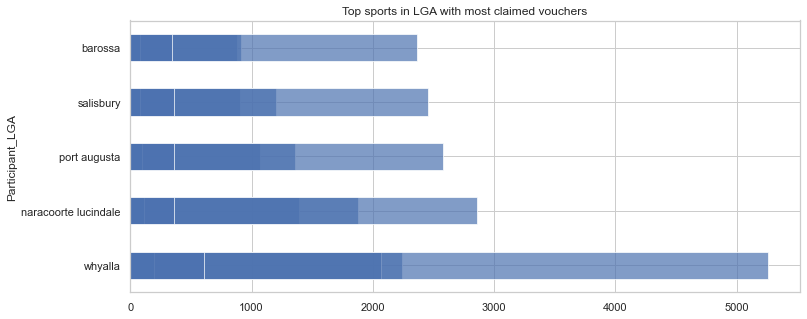

In [44]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))

my_colors = ['b', 'r', 'g', 'y', 'm']

for i in topSports:

    pivot[i].sort_values().nlargest(5).plot(kind='barh', style='b', alpha=0.7,
                  title='Top sports in LGA with most claimed vouchers')
    

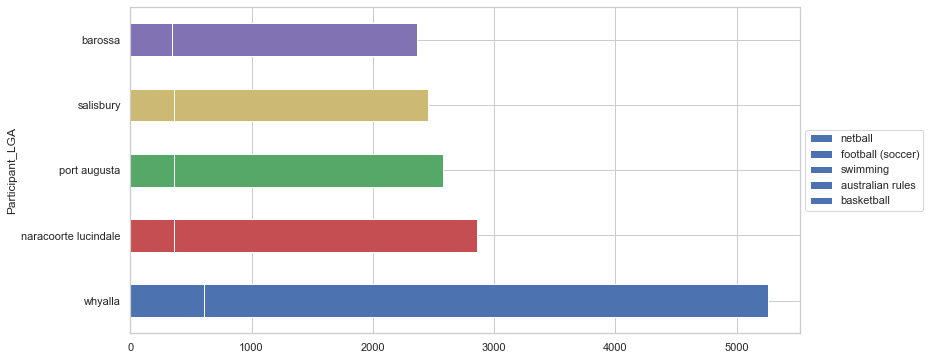

In [45]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))

my_colors = ['b', 'r', 'g', 'y', 'm']

for i in topSports:

    ax = pivot[i].sort_values().nlargest(5).plot(kind='barh', stacked=True, color=my_colors, figsize=(12, 6))
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('Value_Time_Country.png', dpi=300, bbox_inches='tight')

# QUESTIONS 
- trying to get these stacked like in https://seaborn.pydata.org/examples/part_whole_bars.html

below is the plots separately, but i want them all together

In [46]:
topSports

['netball', 'football (soccer)', 'swimming', 'australian rules', 'basketball']

In [47]:
netball = pivot[topSports[0]].sort_values().nlargest(5)
swimming =pivot[topSports[1]].sort_values().nlargest(5)
soccer= pivot[topSports[2]].sort_values().nlargest(5)
afl= pivot[topSports[3]].sort_values().nlargest(5)
basketball = pivot[topSports[4]].sort_values().nlargest(5)

In [48]:
list1 = list(netball.index.values)
list2 = list(swimming.index.values)
list3 = list(soccer.index.values)
list4 = list(afl.index.values)
list5 = list(basketball.index.values)

# mylist = list1.concatenate([list2, list3, list4, list5])

In [58]:
set(list1)

{'adelaide hills',
 'barossa',
 'charles sturt',
 'franklin harbour',
 'marion',
 'mount barker',
 'naracoorte lucindale',
 'onkaparinga',
 'playford',
 'port adelaide enfield',
 'port augusta',
 'salisbury',
 'tea tree gully',
 'west torrens',
 'whyalla'}

In [49]:
list1.extend(list2)

In [52]:
list1.extend(list3)

In [54]:
list1.extend(list4)

In [55]:
list1.extend(list5)

In [55]:
mylist

<Figure size 1080x720 with 0 Axes>

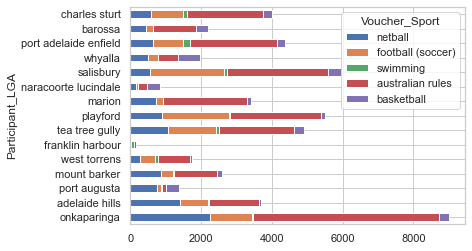

In [62]:
plt.figure(figsize=(15,10))

pivot_top = pivot.loc[set(list1)] 

pivot_top[topSports].plot.barh(stacked=True)


try the normalised charts https://altair-viz.github.io/gallery/normalized_stacked_bar_chart.html

check out matrix plot. one axis is lga and the other its the sport 

since it's not normalised, we don't know the proportions/ popularity

should consider 'other sports' for the less popular sports. 

Participant_LGA
port adelaide enfield    199.0
charles sturt            111.0
salisbury                 99.0
west torrens              80.0
franklin harbour          79.0
Name: swimming, dtype: float64

In [141]:
pivot[topSports]

Voucher_Sport,netball,swimming,football (soccer),australian rules,basketball
Participant_LGA,,,,,
adelaide,23.0,0.0,27.0,130.0,4.0
adelaide hills,1395.0,18.0,812.0,1412.0,48.0
adelaide plains,160.0,3.0,93.0,485.0,15.0
alexandrina,860.0,11.0,510.0,980.0,204.0
barossa,445.0,12.0,197.0,1196.0,341.0
...,...,...,...,...,...
west torrens,268.0,80.0,425.0,907.0,70.0
whyalla,509.0,8.0,268.0,569.0,605.0
wudinna,194.0,0.0,0.0,44.0,0.0


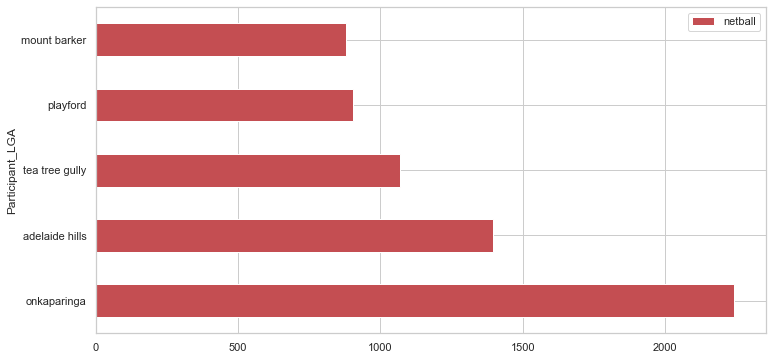

In [145]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))
# fig, axes = plt.subplots(5, 1)

my_colors = ['b', 'r', 'g', 'y', 'm']


netball.plot(kind='barh',stacked=True, color='r', figsize=(12, 6))
# swimming.plot(kind='barh',stacked=True, color='b',figsize=(12, 6))

# soccer.plot(kind='barh',stacked=True, color='g',figsize=(12, 6))

# afl.plot(kind='barh',stacked=True, color='y',figsize=(12, 6))

# basketball.plot(kind='barh',stacked=True, color='m',figsize=(12, 6))


plt.legend()

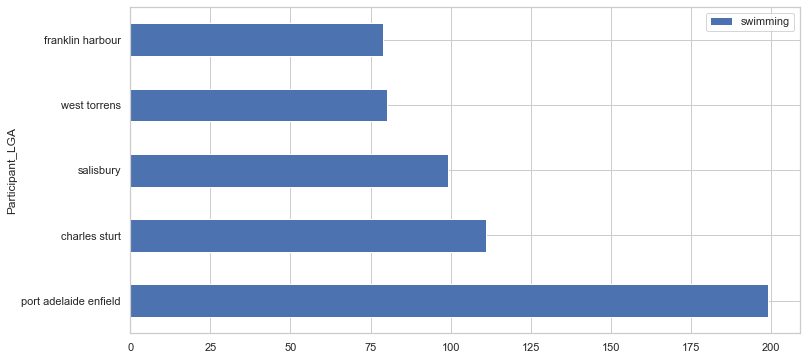

In [146]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))
# fig, axes = plt.subplots(5, 1)

my_colors = ['b', 'r', 'g', 'y', 'm']


# netball.plot(kind='barh',stacked=True, color='r', figsize=(12, 6))
swimming.plot(kind='barh',stacked=True, color='b',figsize=(12, 6))

# soccer.plot(kind='barh',stacked=True, color='g',figsize=(12, 6))

# afl.plot(kind='barh',stacked=True, color='y',figsize=(12, 6))

# basketball.plot(kind='barh',stacked=True, color='m',figsize=(12, 6))


plt.legend()

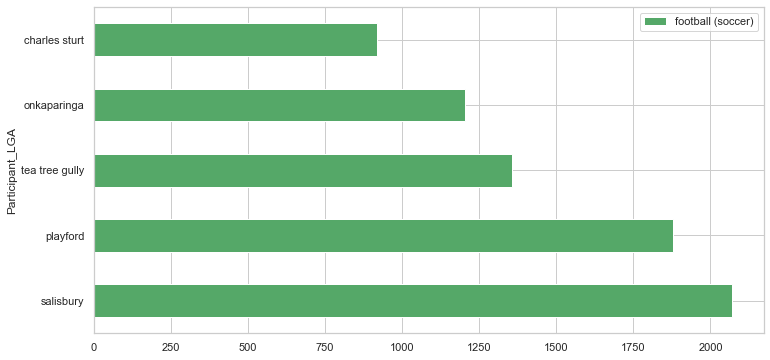

In [147]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))
# fig, axes = plt.subplots(5, 1)

my_colors = ['b', 'r', 'g', 'y', 'm']


# netball.plot(kind='barh',stacked=True, color='r', figsize=(12, 6))
# swimming.plot(kind='barh',stacked=True, color='b',figsize=(12, 6))

soccer.plot(kind='barh',stacked=True, color='g',figsize=(12, 6))

# afl.plot(kind='barh',stacked=True, color='y',figsize=(12, 6))

# basketball.plot(kind='barh',stacked=True, color='m',figsize=(12, 6))


plt.legend()

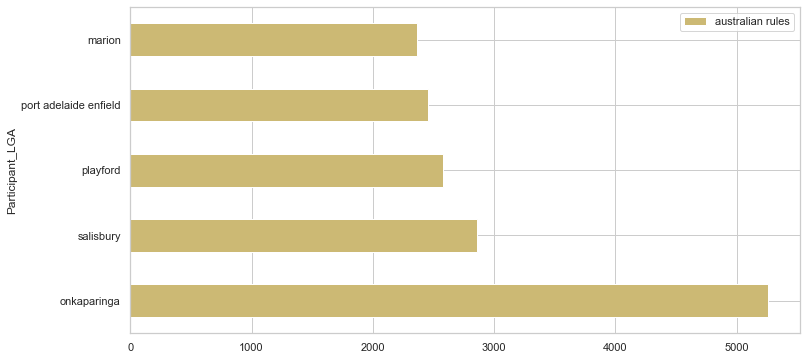

In [148]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))
# fig, axes = plt.subplots(5, 1)

my_colors = ['b', 'r', 'g', 'y', 'm']


# netball.plot(kind='barh',stacked=True, color='r', figsize=(12, 6))
# swimming.plot(kind='barh',stacked=True, color='b',figsize=(12, 6))

# soccer.plot(kind='barh',stacked=True, color='g',figsize=(12, 6))

afl.plot(kind='barh',stacked=True, color='y',figsize=(12, 6))

# basketball.plot(kind='barh',stacked=True, color='m',figsize=(12, 6))


plt.legend()

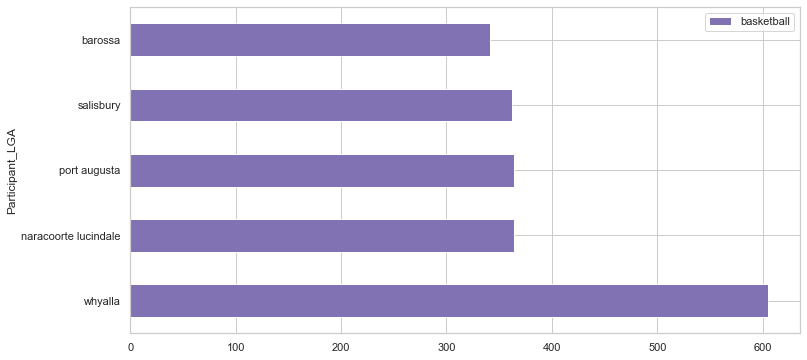

In [149]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12, 5))
# fig, axes = plt.subplots(5, 1)

my_colors = ['b', 'r', 'g', 'y', 'm']


# netball.plot(kind='barh',stacked=True, color='r', figsize=(12, 6))
# swimming.plot(kind='barh',stacked=True, color='b',figsize=(12, 6))

# soccer.plot(kind='barh',stacked=True, color='g',figsize=(12, 6))

# afl.plot(kind='barh',stacked=True, color='y',figsize=(12, 6))

basketball.plot(kind='barh',stacked=True, color='m',figsize=(12, 6))


plt.legend()

We now know the most popular sports, and we know the rank of each sport for each LGA. Appllying the rank function to the most popular sports

I think will have to do a loop for each of the sports in `topSports` 

I want stacked bars, with the stacked bars being the sport. The y axis being the LGA, x axis being the x axis. 

II believe certain sports will be too large like australian rules, compared to basketball. 

we can see what is the most popular sports without the `set` function. This will say what sport  is most popular in each LGA

another way... for each sport, which LGA is most popular 

### Shows which top 10 LGA has the most claimed vouchers

<AxesSubplot:title={'center':'test'}, ylabel='Participant_LGA'>

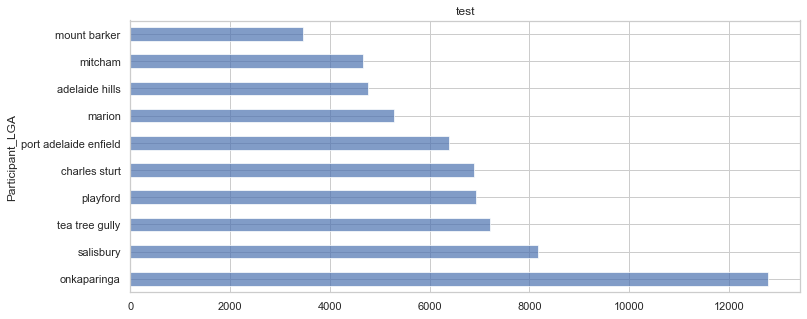

In [73]:
sns.set_theme(style="whitegrid")


fig = plt.figure(figsize=(12, 5))
total = pivot.sum(axis=1).sort_values(ascending=False)
total.nlargest(10).plot(kind='barh', style='b', alpha=0.7,
              title='test')


# plt.savefig('Totalvalue_Country.png', dpi=300, bbox_inches='tight')

In [ ]:
pivot = pd.pivot_table(sa_vouchers_scores, 

# Q3 Are any LGAs over/under represented in their use of vouchers?

Check population to number of vouchers claimed. 

david : need to normalise the vouchers by population in some way 

# Q4 Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [ ]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

In [ ]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()